# NLP (Natural Language Processing)

In this assignment we will see:

   * Part 1: Data
   * Part 2: Basic Exploratory Data Analysis
   * Part 3: Text Pre-Processing
   * Part 4: Vectorization
   * Part 6: Model Evaluation
   * Part 7: Creating a Data Pipeline
    

## Part 1: Data

Read data from "../data/SMSSpamCollection.txt" and print total message in file

In [89]:
import csv

data=[]
with open('SMSSpamCollection.txt','r') as fileRef:
    fileRef = csv.reader(fileRef, delimiter='\t')
    total = 0
    for row in fileRef:
        data
        total += 1
    print(total)

5572


out: 5574

In [90]:
with open("SMSSpamCollection.txt") as fileRef:
    head = [next(fileRef) for x in range(10)]

for count, line in enumerate(head, 0):
  print(count, line)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

1 ham	Ok lar... Joking wif u oni...

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

3 ham	U dun say so early hor... U c already then say...

4 ham	Nah I don't think he goes to usf, he lives around here though

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv

6 ham	Even my brother is not like to speak with me. They treat me like aids patent.

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune

8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341.

Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.


![](http://www.astroml.org/sklearn_tutorial/_images/plot_ML_flow_chart_3.png)

Instead of parsing TSV manually using Python, we can just take advantage of pandas! Let's go ahead and import it!

In [91]:
import pandas as pd

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [92]:
smsData = pd.read_csv('SMSSpamCollection.txt',header=None, delimiter='\t', names=['type', 'msg'])
print(smsData.shape)

(5572, 2)


## Part 2: Basic Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

Apply Describe on dataframe

In [93]:
print(smsData['msg'].describe())

count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
Name: msg, dtype: object


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [94]:
smsData.groupby('type')['msg'].describe()

,count,unique,top,freq
type,,,,
ham,4825,4516,"Sorry, I'll call later",30
spam,747,653,Please call our customer service representativ...,4


As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long(find length) the text messages are:

In [95]:
smsData['length'] = smsData['msg'].apply(len)
smsData.head()

,type,msg,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Let's visualize this! Let's do the imports for matplotlib and seaborn:

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot histogram for length column with bins=50

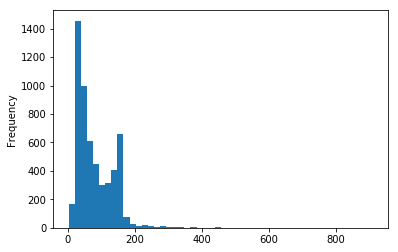

In [97]:
smsData['length'].plot(bins=50, kind='hist')

Play around with the bin size! Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

Describe the length column of messages

In [98]:
smsData['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [99]:
smsData[smsData['length'] == 910]['msg'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

Plot histogram for length by "label" column with bins=50

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000220CDA6A048>,
      dtype=object)

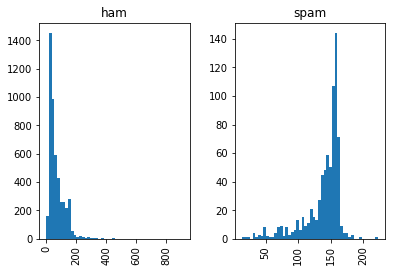

In [100]:
smsData.hist(column='length', by='type', bins=50)

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Part 3: Text pre-processing

Text Pre-Processing functions does:
1. Remove all punctuation
2. Remove all stopwords
3. eturns a list of the cleaned text

In [101]:
import string
from nltk.corpus import stopwords
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Display the original DataFrame again:

In [102]:
print(smsData.head(10))

   type                                                msg  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61
5  spam  FreeMsg Hey there darling it's been 3 week's n...     147
6   ham  Even my brother is not like to speak with me. ...      77
7   ham  As per your request 'Melle Melle (Oru Minnamin...     160
8  spam  WINNER!! As a valued network customer you have...     157
9  spam  Had your mobile 11 months or more? U R entitle...     154


Apply "text_process" function on messages['message'] column

In [103]:
# print(smsData.msg)
smsData['msg'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
5       [FreeMsg, Hey, darling, 3, weeks, word, back, ...
6       [Even, brother, like, speak, treat, like, aids...
7       [per, request, Melle, Melle, Oru, Minnaminungi...
8       [WINNER, valued, network, customer, selected, ...
9       [mobile, 11, months, U, R, entitled, Update, l...
10      [Im, gonna, home, soon, dont, want, talk, stuf...
11      [SIX, chances, win, CASH, 100, 20000, pounds, ...
12      [URGENT, 1, week, FREE, membership, £100000, P...
13      [Ive, searching, right, words, thank, breather...
14                                         [DATE, SUNDAY]
15      [XXXMobileMovieClub, use, credit, click, WAP, ...
16                                    [Oh, kim, watching]
17      [Eh, u

In [104]:
print(smsData.head(10))

   type                                                msg  length
0   ham  Go until jurong point, crazy.. Available only ...     111
1   ham                      Ok lar... Joking wif u oni...      29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3   ham  U dun say so early hor... U c already then say...      49
4   ham  Nah I don't think he goes to usf, he lives aro...      61
5  spam  FreeMsg Hey there darling it's been 3 week's n...     147
6   ham  Even my brother is not like to speak with me. ...      77
7   ham  As per your request 'Melle Melle (Oru Minnamin...     160
8  spam  WINNER!! As a valued network customer you have...     157
9  spam  Had your mobile 11 months or more? U R entitle...     154


## Part 4: Vectorization

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

Load CountVectorizer from sklearn

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [106]:
#print(smsData['msg'])
vectorizer = CountVectorizer(analyzer=text_process)
vect = vectorizer.fit(smsData['msg'])
print(len(vectorizer.get_feature_names()))


11425


out: 11425

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [107]:
textMsg = smsData['msg'][3]
print(textMsg)

U dun say so early hor... U c already then say...


out: U dun say so early hor... U c already then say...

Now let's see its vector representation:

In [108]:
bowTransformerSingleMsg = vectorizer.transform([textMsg])
print(bowTransformerSingleMsg)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


This means that there are seven unique words in message number 4 (after removing common stop words). Two of them appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice:

In [109]:
print(vectorizer.get_feature_names()[4068])
print(vectorizer.get_feature_names()[9554])

U
say


Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [110]:
bowTransformer = vectorizer.transform(smsData['msg'])

print('Shape:', bowTransformer.shape)
print('Amount of Non-Zero occurences:', bowTransformer.nnz)
sparsity = (100.0 * bowTransformer.nnz / (bowTransformer.shape[0] * bowTransformer.shape[1]))
print('sparsity:', sparsity)

Shape: (5572, 11425)
Amount of Non-Zero occurences: 50548
sparsity: 0.07940295412668218


Shape of Sparse Matrix:  (5572, 11425)<br>
Amount of Non-Zero occurences:  50548<br>
sparsity: 0.08%

After the counting, the term weighting and normalization can be done with [TF-IDF]

Let's go ahead and see how we can do this in SciKit Learn:

Load TfidfTransformer from sklearn and transform "messages_bow" and print tfidf score

In [111]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer().fit(bowTransformer)
tfidf = tfidfTransformer.transform(bowTransformerSingleMsg)
print(tfidf)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

In [112]:
print(tfidfTransformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidfTransformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


3.28005242674<br>
8.5270764989

Transform the entire bag-of-words corpus into TF-IDF corpus at once and print shape

In [113]:
msgTfidf = tfidfTransformer.transform(bowTransformer)
print(msgTfidf.shape)

(5572, 11425)


(5572, 11425)

There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit learn's documentation on dealing with text data as well as the expansive collection of availble papers and books on the general topic of NLP.

## Part 5: Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with: Import MultinomialNB and create the model using messages_tfidf as data and messages['label'] as label

In [114]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(msgTfidf, smsData['type'])

Let's try classifying our message4 and checking how we do:

In [115]:
print(model.predict(tfidf4)[0])

ham


Fantastic We've developed a model that can attempt to predict spam vs ham classification!

## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's beginby getting all the predictions:

In [118]:
predictions = model.predict(msgTfidf)
print(predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png)

Display classification_report for above model

In [119]:
from sklearn.metrics import classification_report
print (classification_report(smsData['type'], predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

   micro avg       0.98      0.98      0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

Load train_test_split using skelarn with test_size=0.2 and print length of train and text data

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(smsData['msg'], smsData['type'], test_size=0.2)

print('X train: ', len(X_train), '/', len(smsData['msg']))
print('X_test: ', len(X_test), '/', len(smsData['msg']))

X train:  4457 / 5572
X_test:  1115 / 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Part 7: Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

Create Pipeline for CountVectorizer, TfidfTransformer and MultinomialNB

In [122]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('countVectorizer', CountVectorizer()),
    ('tfidfTransformer', TfidfTransformer()),
    ('multinomialNB', MultinomialNB()),
])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [123]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('countVectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...alse, use_idf=True)), ('multinomialNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Predict it on test Message

In [124]:
prediction = pipeline.predict(X_test)
print(prediction)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


Display Classification Report

In [125]:
from sklearn import metrics
print(metrics.classification_report(prediction, y_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.97      1011
        spam       0.66      1.00      0.79       104

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.83      0.97      0.88      1115
weighted avg       0.97      0.95      0.96      1115



Now we have a classification report for our model on a true testing set! There is a lot more to Natural Language Processing than what we've covered here, and its vast expanse of topic could fill up several college courses! I encourage you to check out the resources below for more information on NLP!

# Good Job!